In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# imports

import numpy
from  qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.operators.second_quantization.qubit_converter import QubitConverter
from qiskit.aqua.components.optimizers import L_BFGS_B
from qiskit import Aer
from qiskit_nature.circuit.library import UCCSD
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.opflow import I,X,Y,Z
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.operators.legacy import op_converter
from qiskit.aqua.algorithms import VQE
from qiskit.aqua import QuantumInstance
from tqdm import tqdm
from joblib import Parallel, delayed
import itertools
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute
from qiskit.circuit.library import U3Gate
from qiskit.aqua.components.initial_states import Custom
from qiskit.chemistry.components.initial_states import HartreeFock
import scipy
import matplotlib.pyplot as plt

from qiskit.providers.aer.extensions.snapshot_statevector import *
from qiskit.quantum_info.operators import Operator
import numpy as np
from scipy.linalg import expm
import copy

C:\Users\abhuynh\Miniconda3\envs\qiskit\lib\site-packages\qiskit\chemistry\__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


In [3]:
# basic setup

PAULI_X = np.array([[0,1],[1,0]], dtype='complex128')
PAULI_Y = np.array([[0,-1j],[1j,0]], dtype='complex128')
PAULI_Z = np.array([[1,0],[0,-1]], dtype='complex128')
IDENTITY = np.eye(2, dtype='complex128')

def pauli_string_to_matrix(pauli_string):
    return Pauli(pauli_string).to_matrix()

def pauli_string_exp_to_matrix(pauli_string, param):
    return expm(-1j * param * Pauli(pauli_string).to_matrix())


backend = Aer.get_backend('statevector_simulator')
qasm_backend = Aer.get_backend('qasm_simulator')


In [4]:
# circuit creation

def rotate_state(pauli_string, param, circuit):
    ancilla_boolean = (1 if circuit.num_qubits == 5 else 0)
    if pauli_string == 'IIII':
        gate = 1
        for j in range(len(pauli_string)):
            gate = np.kron(gate, IDENTITY)
        gate *= -1j * np.sin(param)
        gate += np.cos(param) * np.eye(16)
        qubits_to_act_on = [1,2,3,4] if ancilla_boolean else [0,1,2,3]
        circuit.unitary(gate, qubits_to_act_on, label=pauli_string)
    else:
        qubits_to_act_on = []
        gate = 1
        for j in range(len(pauli_string)):
            if pauli_string[j] == 'X':
                gate = np.kron(gate, PAULI_X)
            elif pauli_string[j] == 'Y':
                gate = np.kron(gate, PAULI_Y)
            elif pauli_string[j] == 'Z':
                gate = np.kron(gate, PAULI_Z)
            if pauli_string[j] != 'I':
                qubits_to_act_on.append(np.abs(j - 3) + (0,1)[ancilla_boolean])
        gate *= (-1j * np.sin(param))
        gate += np.cos(param) * np.eye(2**len(qubits_to_act_on))
        qubits_to_act_on.reverse()
        circuit.unitary(gate, qubits_to_act_on, label = pauli_string)
        circuit.barrier()

def create_initial_state():
    circuit = QuantumCircuit(4)
    circuit.x(0)
    circuit.x(2)
    circuit.barrier()
    return circuit

def create_adapt_ground_state():
    labels = ['IIXY', 'XYII', 'IZXY']
    params = [-0.7853980948120887, -0.7853983093282092, 0.23182381954801887]
    circuit = create_initial_state()
    for i in range(len(labels)):
        rotate_state(labels[i], params[i], circuit)
    return circuit

def create_excited_state():
    labels=['IIXY', 'XYII', 'IZXY','IIXZ','IIII']
    params=[-0.7853980948120887, -0.7853983093282092, 0.23182381954801887,numpy.pi/2,-numpy.pi/2.] 
    circuit = create_initial_state()
    for i in range(len(labels)):
        rotate_state(labels[i], params[i], circuit)
    circuit.barrier()
    return circuit

excited_state = execute(create_excited_state(), backend).result().get_statevector()

def create_excited_state2():
    labels = ['IIXY', 'XYII', 'IZXY', 'IIII', 'IIIY']
    params = [-0.7853980948120887, -0.7853983093282092, 0.23182381954801887, -numpy.pi/2, numpy.pi/2]
    circuit = create_initial_state()
    for i in range(len(labels)):
        rotate_state(labels[i], params[i], circuit)
    return circuit

excited_state2 = execute(create_excited_state2(), backend).result().get_statevector()

In [5]:
# hubbard model

#2 site Hubbard model params
t = 1 # hopping integral
U = 2 # interaction strength for a site occupied by 2 fermions
mu = U / 2 # chemical potential

# define 2x1 Hubbard Hamiltonian
# num_spin_orbitals is the number of possible spin orbital states for a site: e.g. empty, up, down, or superposition
def HubbardHamiltonian(U, t, num_spin_orbitals, num_particles):
        h1=numpy.zeros((4,4))
        h2=numpy.zeros((4,4,4,4))
        num_sites = int(num_spin_orbitals / 2)
        for i in range(num_sites - 1):
            h1[i, i + 1] = h1[i + 1, i] = -t
            h1[i + num_sites, i + 1 + num_sites] = h1[i + 1 + num_sites,i + num_sites] = -t
            h1[i][i] = -mu
            h1[i + num_sites][i + num_sites] = -mu
        h1[num_sites - 1][num_sites - 1] = -mu
        h1[2*num_sites - 1][2*num_sites - 1] =  -mu    
        h1[0, num_sites - 1] = h1[num_sites - 1, 0] = -t
        h1[num_sites, 2*num_sites - 1] = h1[2*num_sites - 1, num_sites] = -t
        for i in range(num_sites):
            h2[i, i , i + num_sites, i + num_sites] = U
        fermion_op = fermionic_op_builder.build_ferm_op_from_ints(h1, h2) # Fermionic Hamiltonian
        mapper = JordanWignerMapper()
        qubit_op = mapper.map(fermion_op)
        return qubit_op
    
qubit_op = Pauli('XX').to_matrix() + Pauli('ZZ').to_matrix()

#construct the qubit operator rep. of the 2x1 Hubbard model
qubit_H=HubbardHamiltonian(U = 2, t = 1, num_spin_orbitals = 4, num_particles = 2)
#constructing matrix rep. in the Fock space
H_mat=qubit_H.to_matrix(massive=True)

#exact ground state
exact_eigenvalues, exact_eigenvectors = numpy.linalg.eigh(H_mat)
exact_ground_state_energy = exact_eigenvalues[0]
# print("ground state energy: ", exact_ground_state_energy)
exact_ground_state_wavefunction = exact_eigenvectors[:,0] #this is |G>
# print("ground state wavefunction: \n", exact_ground_state_wavefunction)

def time_evolution_operator(t):
    return exact_eigenvectors @ numpy.diag(numpy.exp(-1j * exact_eigenvalues * t)) @ numpy.conjugate(exact_eigenvectors.T)

def greens_function(t, dt, initial_t):
    steps = int((t - initial_t) / dt)
    t_arr = numpy.linspace(initial_t, t, steps)
    exact_greens_function_list = []
    for i in tqdm(range(len(t_arr))):
        #evaluations at time step t_i
        unitary_t = time_evolution_operator(t_arr[i])
        #exact evolved excited state
        exact_evolved_state = numpy.dot(unitary_t, excited_state)
        single_greens_function = numpy.exp(1j*(U - rho) / 2) * numpy.dot(numpy.conjugate(excited_state2), exact_evolved_state)
        exact_greens_function_list.append(single_greens_function)
    return exact_greens_function_list

t = 1
dt = 0.01
initial_t = 0
steps=int((t - initial_t) / dt)
t_arr=numpy.linspace(initial_t, t, steps)
rho=numpy.sqrt(U ** 2+16 * t * t)
G=greens_function(t, dt, initial_t)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 49107.88it/s]


## Begin circuit implementation

In [6]:
def create_circuit_ancilla(ancilla_boolean):
    circuit = QuantumCircuit(4 + (0,1)[ancilla_boolean])
    circuit.x(0 + (0,1)[ancilla_boolean])
    circuit.x(2 + (0,1)[ancilla_boolean])
    labels=['IIXY', 'XYII', 'IZXY','IIXZ','IIII']
    params=[-0.7853980948120887, -0.7853983093282092, 0.23182381954801887,numpy.pi/2,-numpy.pi/2.] 
    for i in range(len(labels)):
        rotate_state(labels[i], params[i], circuit)   
    circuit.barrier()
    return circuit

In [7]:
def controlled_rotate_state(pauli_string, param, circuit):
    if pauli_string == 'IIII':
        return
    num_qubits = 4 #the ancilla does not count
    qubits_to_act_on = []
    gate = 1
    for j in range(len(pauli_string)):
        if pauli_string[j] == 'X':
            gate = np.kron(gate, PAULI_X)
        elif pauli_string[j] == 'Y':
            gate = np.kron(gate, PAULI_Y)
        elif pauli_string[j] == 'Z':
            gate = np.kron(gate, PAULI_Z)
        if pauli_string[j] != 'I':
            qubits_to_act_on.append(np.abs(j - num_qubits + 1) + 1)
    qubits_to_act_on.reverse()

    #convert unitary to gate through a temporary circuit
    temp_circuit = QuantumCircuit(2)
    temp_circuit.unitary(gate, [0, 1]) #we only have controlled 2-qubit unitaries: IIXX, XXII, IIYY, YYII, ZIZI, IZIZ
    controlled_gate = temp_circuit.to_gate(label = 'Controlled ' + pauli_string).control(1)
    qubits_to_act_on.insert(0, 0) #insert ancilla bit to front of list
    circuit.append(controlled_gate, qubits_to_act_on)

In [8]:
from qiskit.quantum_info import partial_trace, Statevector

def measure_ancilla(circuit, shots):
    classical_register = ClassicalRegister(1, 'classical_reg')
    circuit.add_register(classical_register)
    circuit.measure(0, classical_register[0])

    result = execute(circuit, qasm_backend, shots = shots).result() 
    counts = result.get_counts(circuit)
    if counts.get('0') != None:
        return 2 * (result.get_counts(circuit)['0'] / shots) - 1
    else:
        return -1

def measure_ancilla_statevector(circuit):
    full_statevector = Statevector(circuit)
    partial_density_matrix = partial_trace(full_statevector, [1, 2, 3, 4])
    partial_statevector = np.diagonal(partial_density_matrix)
    return ((2 * partial_statevector[0]) - 1).real    

## Calculation of M,V

In [9]:
def calculate_m_statevector(p, q, vqs_generators, vqs_params):
    circuit = create_circuit_ancilla(True) #Creates |E>

    circuit.h(0)
    circuit.x(0)
    circuit.barrier()
    
    for i in range(0, p):
        rotate_state(vqs_generators[i], vqs_params[i], circuit)
    circuit.barrier()

    controlled_rotate_state(vqs_generators[p], vqs_params[p], circuit)
    circuit.barrier()

    for i in range(p, q):
        rotate_state(vqs_generators[i], vqs_params[i], circuit)
    circuit.barrier()

    circuit.x(0)
    controlled_rotate_state(vqs_generators[q], vqs_params[q], circuit)
    circuit.h(0)
    circuit.barrier()
    return measure_ancilla_statevector(circuit)

def calculate_v_statevector(p, vqs_generators, vqs_params):
    n_theta = len(vqs_params)    
    circuit = create_circuit_ancilla(True)

    circuit.h(0)
    circuit.x(0)
    
    for i in range(0, p):
        rotate_state(vqs_generators[i], vqs_params[i], circuit)
    circuit.barrier()

    controlled_rotate_state(vqs_generators[p], vqs_params[p], circuit)
    circuit.barrier()

    for i in range(p, n_theta):
        rotate_state(vqs_generators[i], vqs_params[i], circuit)
    circuit.barrier()

    circuit.x(0)

    coeffs = [0.5, 0.5, -0.5, -0.5, -0.5, -0.5, -1.0]
    measurements = []
    for i in range(len(coeffs)):
        single_h_circuit = copy.deepcopy(circuit)
        controlled_rotate_state(vqs_generators[i], coeffs[i], single_h_circuit)
        single_h_circuit.h(0)
        measurements.append(measure_ancilla_statevector(single_h_circuit))
    results = 0
    for i in range(len(coeffs)):
        results += measurements[i] * coeffs[i]
    return results

def calculate_m_shots(p, q, vqs_params, shots):
    circuit = create_circuit_ancilla(True) #Creates |E>

    circuit.h(0)
    circuit.x(0)
    circuit.barrier()
    
    for i in range(0, p):
        rotate_state(vqs_generators[i], vqs_params[i], circuit)
    circuit.barrier()

    controlled_rotate_state(vqs_generators[p], vqs_params[p], circuit)
    circuit.barrier()

    for i in range(p, q):
        rotate_state(vqs_generators[i], vqs_params[i], circuit)
    circuit.barrier()

    circuit.x(0)
    controlled_rotate_state(vqs_generators[q], vqs_params[q], circuit)
    circuit.h(0)
    circuit.barrier()
    return measure_ancilla(circuit, shots)

def calculate_v_shots(p, vqs_params, shots):
    n_theta = len(vqs_params)    
    circuit = create_circuit_ancilla(True)

    circuit.h(0)
    circuit.x(0)
    
    for i in range(0, p):
        rotate_state(vqs_generators[i], vqs_params[i], circuit)
    circuit.barrier()

    controlled_rotate_state(vqs_generators[p], vqs_params[p], circuit)
    circuit.barrier()

    for i in range(p, n_theta):
        rotate_state(vqs_generators[i], vqs_params[i], circuit)
    circuit.barrier()

    circuit.x(0)

    coeffs = [0.5, 0.5, -0.5, -0.5, -0.5, -0.5, -1.0]
    measurements = []
    for i in range(len(coeffs)):
        single_h_circuit = copy.deepcopy(circuit)
        controlled_rotate_state(vqs_generators[i], coeffs[i], single_h_circuit)
        single_h_circuit.h(0)
        measurements.append(measure_ancilla(single_h_circuit, shots))
    results = 0
    for i in range(len(coeffs)):
        results += measurements[i] * coeffs[i]
    return results

In [10]:
        ####################################### calculating McLachlan #######################################
#         m_matrix = numpy.array([[1,-1, 0, 0, 0, 0, 0],
#                                 [-1,1, 0, 0, 0, 0, 0],
#                                 [0, 0, 1,-1,-1,-1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0, 0, 0, 0, 0, 1]]) + 0.0
#         m_indices = [(0,6),(1,6),(2,6),(3,6),(4,6),(5,6)]

#         else:
#             m_elements = Parallel(n_jobs=-1)(delayed(calculate_m_shots)(m_indices[i][0], m_indices[i][1], vqs_params, shots) for i in range(len(m_indices)))            
#             v_vector = Parallel(n_jobs=-1)(delayed(calculate_v_shots)(p, vqs_params, shots) for p in range(len(vqs_params)))
 
#         theta_dot = np.array([0, 0, 0.25, -0.25, -0.25, -0.25, -1])
#         theta_dot = tikhonov_regularization(m_matrix, v_vector, 0.01)            

#         print("|M - \\thetaDot - V| = ", numpy.sum(numpy.abs(m_matrix@theta_dot-v_vector)))


In [11]:
def tikhonov_regularization(A, b, multiplier):
    A = np.array(A)
    b = np.array(b)
    Gamma = np.eye(len(b)) * multiplier
    return np.linalg.inv(np.transpose(A)@A + np.transpose(Gamma)@Gamma)@np.transpose(A)@b

In [86]:
def calculate_error(theta_dot, m_matrix, v_vector):
    return numpy.sum((numpy.dot(m_matrix, theta_dot) - v_vector) ** 2)

def McEvolve(initial_vqs_params, t, dt, initial_t, shots): 
    steps=int((t-initial_t)/dt)
    t_arr=numpy.linspace(initial_t,t,steps)
    vqs_params = initial_vqs_params
    vqs_dot_hist=[]
    vqs_hist=[copy.deepcopy(vqs_params)]
    fidelity_hist = []

    for i in tqdm(range(len(t_arr))):
        circuit = create_excited_state()

        # evaluations at time step t_i
        U_T=time_evolution_operator(t_arr[i])
    
        # exact state:
        exact_evolved_state = U_T @ excited_state #e^-iHt|psi>
        
        # simulated state:
        for vqs_index in range(len(vqs_generators)):
            rotate_state(vqs_generators[vqs_index], vqs_hist[-1][vqs_index], circuit)
        vqs_state = execute(circuit, backend).result().get_statevector()

        fidelity = numpy.abs(numpy.dot(vqs_state,numpy.conjugate(exact_evolved_state)))**2
        fidelity_hist.append(fidelity)
        print("Fidelity: ", fidelity)

        # ALL CALCULATION CASE
        m_matrix = np.zeros((len(vqs_params),len(vqs_params)))
        m_indices = [(p,q) for p in range(len(vqs_params)) for q in range(len(vqs_params)) if p <= q]
       
        # 13 CALCULATION CASE
#         m_matrix = numpy.array([[1,-1, 0, 0, 0, 0, 0],
#                                 [-1,1, 0, 0, 0, 0, 0],
#                                 [0, 0, 1,-1,-1,-1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0, 0, 0, 0, 0, 1]]) + 0.0
#         m_indices = [(0,6),(1,6),(2,6),(3,6),(4,6),(5,6)]

        # 11 CALCULATION CASE
#         m_matrix = numpy.array([[1,-1, 0, 0, 0, 0, 0.4472136224179821],
#                                 [-1,1, 0, 0, 0, 0, -0.4472136224179821],
#                                 [0, 0, 1,-1,-1,-1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0.4472136224179821, -0.4472136224179821, 0, 0, 0, 0, 1]]) + 0.0
#         m_indices = [(2,6),(3,6),(4,6),(5,6)]

        # 8 CALCULATION CASE
#         m_matrix = numpy.array([[1,-1, 0, 0, 0, 0, 0.4472136224179821],
#                                 [-1,1, 0, 0, 0, 0, -0.4472136224179821],
#                                 [0, 0, 1,-1,-1,-1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0, 0,-1, 1, 1, 1, 0],
#                                 [0.4472136224179821, -0.4472136224179821, 0, 0, 0, 0, 1]]) + 0.0
#         m_indices = [(2,6)]

        if shots == None:
            m_elements = Parallel(n_jobs=-1)(delayed(calculate_m_statevector)(m_indices[i][0], m_indices[i][1], vqs_generators, vqs_params) for i in range(len(m_indices)))       
            v_vector = Parallel(n_jobs=-1)(delayed(calculate_v_statevector)(p, vqs_generators, vqs_params) for p in range(len(vqs_params)))
        else:
            m_elements = Parallel(n_jobs=-1)(delayed(calculate_m_shots)(m_indices[i][0], m_indices[i][1], vqs_params, shots) for i in range(len(m_indices)))            
            v_vector = Parallel(n_jobs=-1)(delayed(calculate_v_shots)(p, vqs_params, shots) for p in range(len(vqs_params)))
     
        for p in range(len(m_indices)):
            m_matrix[m_indices[p][0]][m_indices[p][1]] = m_matrix[m_indices[p][1]][m_indices[p][0]] = m_elements[p]
#         m_matrix[2][6] = m_matrix[6][2] = m_elements[0]
#         m_matrix[3][6] = m_matrix[6][3] = -m_elements[0]
#         m_matrix[4][6] = m_matrix[6][4] = -m_elements[0]
#         m_matrix[5][6] = m_matrix[6][5] = -m_elements[0]
        
        
#         print(m_matrix)

        if shots == None:
            theta_dot = numpy.linalg.lstsq(m_matrix, v_vector, rcond=None)[0]
        else:
            theta_dot = tikhonov_regularization(m_matrix, v_vector, 0.01)            
#         theta_dot = np.array([0, 0, 0.25, -0.25, -0.25, -0.25, -1])

        vqs_dot_hist.append(theta_dot)

        vqs_params += (vqs_dot_hist[-1].real * dt)
        vqs_hist.append(copy.deepcopy(vqs_params))
        
    return vqs_hist, fidelity_hist  

# Run simulation

In [95]:
# simulation setup
t = 50
dt = .1
initial_t = 0

depth = 1
shots = 2**18
vqs_generators = ['ZIZI','IZIZ','IIXX','IIYY','XXII','YYII','IIII'] * depth
vqs_params = numpy.zeros(len(vqs_generators))
print('Depth: ', depth, ' | Shots: ', shots)

vqs_params_history, fidelity_list = McEvolve(vqs_params, t, dt, initial_t, shots)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

Depth:  1  | Shots:  131072
Fidelity:  1.0


  0%|▏                                                                                 | 1/500 [00:02<17:02,  2.05s/it]

Fidelity:  0.9999991867959307


  0%|▎                                                                                 | 2/500 [00:04<20:11,  2.43s/it]

Fidelity:  0.9999715436987728


  1%|▍                                                                                 | 3/500 [00:06<18:45,  2.27s/it]

Fidelity:  0.9998671895221858


  1%|▋                                                                                 | 4/500 [00:09<19:07,  2.31s/it]

Fidelity:  0.9997607563635976


  1%|▊                                                                                 | 5/500 [00:11<18:39,  2.26s/it]

Fidelity:  0.9996459792158278


  1%|▉                                                                                 | 6/500 [00:13<19:03,  2.31s/it]

Fidelity:  0.9996401015802402


  1%|█▏                                                                                | 7/500 [00:15<18:19,  2.23s/it]

Fidelity:  0.999536972583901


  2%|█▎                                                                                | 8/500 [00:18<18:34,  2.27s/it]

Fidelity:  0.9994088692759184


  2%|█▍                                                                                | 9/500 [00:20<18:36,  2.27s/it]

Fidelity:  0.9992783802258162


  2%|█▌                                                                               | 10/500 [00:23<20:52,  2.56s/it]

Fidelity:  0.9993134947845371


  2%|█▊                                                                               | 11/500 [00:26<20:45,  2.55s/it]

Fidelity:  0.9993296832553445


  2%|█▉                                                                               | 12/500 [00:28<21:18,  2.62s/it]

Fidelity:  0.9992638822699882


  3%|██                                                                               | 13/500 [00:31<21:08,  2.61s/it]

Fidelity:  0.9992102537752503


  3%|██▎                                                                              | 14/500 [00:34<21:29,  2.65s/it]

Fidelity:  0.9991570364532625


  3%|██▍                                                                              | 15/500 [00:36<21:10,  2.62s/it]

Fidelity:  0.9991988034501192


  3%|██▌                                                                              | 16/500 [00:40<22:33,  2.80s/it]

Fidelity:  0.9991647859657313


  3%|██▊                                                                              | 17/500 [00:42<21:46,  2.71s/it]

Fidelity:  0.9989802267668105


  4%|██▉                                                                              | 18/500 [00:45<22:58,  2.86s/it]

Fidelity:  0.9989840353064978


  4%|███                                                                              | 19/500 [00:48<22:05,  2.76s/it]

Fidelity:  0.9988159289563369


  4%|███▏                                                                             | 20/500 [00:51<22:16,  2.78s/it]

Fidelity:  0.9987364529324757


  4%|███▍                                                                             | 21/500 [00:53<21:39,  2.71s/it]

Fidelity:  0.9987823827528701


  4%|███▌                                                                             | 22/500 [00:56<21:59,  2.76s/it]

Fidelity:  0.9987369070026375


  5%|███▋                                                                             | 23/500 [00:59<21:26,  2.70s/it]

Fidelity:  0.9986572765113478


  5%|███▉                                                                             | 24/500 [01:01<21:38,  2.73s/it]

Fidelity:  0.9987180918588524


  5%|████                                                                             | 25/500 [01:04<21:05,  2.66s/it]

Fidelity:  0.9986936912489573


  5%|████▏                                                                            | 26/500 [01:07<21:27,  2.72s/it]

Fidelity:  0.9986941033158788


  5%|████▎                                                                            | 27/500 [01:09<21:03,  2.67s/it]

Fidelity:  0.9986642380121871


  6%|████▌                                                                            | 28/500 [01:12<21:55,  2.79s/it]

Fidelity:  0.9985869674636058


  6%|████▋                                                                            | 29/500 [01:15<21:21,  2.72s/it]

Fidelity:  0.9985503238167495


  6%|████▊                                                                            | 30/500 [01:18<21:28,  2.74s/it]

Fidelity:  0.9984167453995182


  6%|█████                                                                            | 31/500 [01:20<21:00,  2.69s/it]

Fidelity:  0.9984218525917848


  6%|█████▏                                                                           | 32/500 [01:23<21:27,  2.75s/it]

Fidelity:  0.9984252458099403


  7%|█████▎                                                                           | 33/500 [01:26<20:55,  2.69s/it]

Fidelity:  0.9984098738033238


  7%|█████▌                                                                           | 34/500 [01:29<22:08,  2.85s/it]

Fidelity:  0.998419139823761


  7%|█████▋                                                                           | 35/500 [01:31<21:16,  2.75s/it]

Fidelity:  0.9982480543530274


  7%|█████▊                                                                           | 36/500 [01:34<21:36,  2.79s/it]

Fidelity:  0.9981509800887522


  7%|█████▉                                                                           | 37/500 [01:37<20:53,  2.71s/it]

Fidelity:  0.9981262166098096


  8%|██████▏                                                                          | 38/500 [01:40<22:16,  2.89s/it]

Fidelity:  0.9981411138642332


  8%|██████▎                                                                          | 39/500 [01:43<21:35,  2.81s/it]

Fidelity:  0.998072278980179


  8%|██████▍                                                                          | 40/500 [01:46<21:43,  2.83s/it]

Fidelity:  0.9980258792206296


  8%|██████▋                                                                          | 41/500 [01:48<21:02,  2.75s/it]

Fidelity:  0.9980236117160646


  8%|██████▊                                                                          | 42/500 [01:52<22:19,  2.92s/it]

Fidelity:  0.9980770798919811


  9%|██████▉                                                                          | 43/500 [01:54<21:32,  2.83s/it]

Fidelity:  0.9979309216997133


  9%|███████▏                                                                         | 44/500 [01:57<21:32,  2.83s/it]

Fidelity:  0.9977607840263727


  9%|███████▎                                                                         | 45/500 [02:00<21:01,  2.77s/it]

Fidelity:  0.9978600420701282


  9%|███████▍                                                                         | 46/500 [02:03<22:23,  2.96s/it]

Fidelity:  0.9977870249870033


  9%|███████▌                                                                         | 47/500 [02:06<21:28,  2.84s/it]

Fidelity:  0.9977929329239192


 10%|███████▊                                                                         | 48/500 [02:09<22:43,  3.02s/it]

Fidelity:  0.9976715854133026


 10%|███████▉                                                                         | 49/500 [02:12<22:03,  2.93s/it]

Fidelity:  0.9977504021339173


 10%|████████                                                                         | 50/500 [02:15<21:46,  2.90s/it]

Fidelity:  0.9977096509560247


 10%|████████▎                                                                        | 51/500 [02:17<21:20,  2.85s/it]

Fidelity:  0.9976590540144892


 10%|████████▍                                                                        | 52/500 [02:21<22:16,  2.98s/it]

Fidelity:  0.9976746187508402


 11%|████████▌                                                                        | 53/500 [02:23<21:11,  2.85s/it]

Fidelity:  0.9975591418545405


 11%|████████▋                                                                        | 54/500 [02:27<22:12,  2.99s/it]

Fidelity:  0.9975574812224188


 11%|████████▉                                                                        | 55/500 [02:29<21:00,  2.83s/it]

Fidelity:  0.9975217547841401


 11%|█████████                                                                        | 56/500 [02:32<21:07,  2.85s/it]

Fidelity:  0.9974557706087871


 11%|█████████▏                                                                       | 57/500 [02:34<20:26,  2.77s/it]

Fidelity:  0.9973335876677212


 12%|█████████▍                                                                       | 58/500 [02:37<20:28,  2.78s/it]

Fidelity:  0.9971728208852988


 12%|█████████▌                                                                       | 59/500 [02:40<20:01,  2.72s/it]

Fidelity:  0.9972009689361322


 12%|█████████▋                                                                       | 60/500 [02:43<20:12,  2.75s/it]

Fidelity:  0.9970811325680006


 12%|█████████▉                                                                       | 61/500 [02:45<19:41,  2.69s/it]

Fidelity:  0.9971292392562872


 12%|██████████                                                                       | 62/500 [02:49<21:00,  2.88s/it]

Fidelity:  0.997238349966408


 13%|██████████▏                                                                      | 63/500 [02:51<20:28,  2.81s/it]

Fidelity:  0.9971135971068507


 13%|██████████▎                                                                      | 64/500 [02:54<21:22,  2.94s/it]

Fidelity:  0.9969613712409212


 13%|██████████▌                                                                      | 65/500 [02:57<20:33,  2.83s/it]

Fidelity:  0.9969515602132869


 13%|██████████▋                                                                      | 66/500 [03:00<20:51,  2.88s/it]

Fidelity:  0.9969361880087603


 13%|██████████▊                                                                      | 67/500 [03:03<20:09,  2.79s/it]

Fidelity:  0.9969568898380515


 14%|███████████                                                                      | 68/500 [03:06<21:07,  2.94s/it]

Fidelity:  0.9970822198987997


 14%|███████████▏                                                                     | 69/500 [03:08<20:17,  2.82s/it]

Fidelity:  0.9969777729350341


 14%|███████████▎                                                                     | 70/500 [03:11<20:43,  2.89s/it]

Fidelity:  0.9971683498761361


 14%|███████████▌                                                                     | 71/500 [03:14<20:05,  2.81s/it]

Fidelity:  0.9970605612125298


 14%|███████████▋                                                                     | 72/500 [03:17<20:23,  2.86s/it]

Fidelity:  0.9970977589897958


 15%|███████████▊                                                                     | 73/500 [03:20<19:47,  2.78s/it]

Fidelity:  0.9970141980736045


 15%|███████████▉                                                                     | 74/500 [03:22<19:42,  2.78s/it]

Fidelity:  0.996865516709985


 15%|████████████▏                                                                    | 75/500 [03:25<19:13,  2.71s/it]

Fidelity:  0.9967613612340358


 15%|████████████▎                                                                    | 76/500 [03:28<19:24,  2.75s/it]

Fidelity:  0.9967747377597101


 15%|████████████▍                                                                    | 77/500 [03:30<18:52,  2.68s/it]

Fidelity:  0.996741475301538


 16%|████████████▋                                                                    | 78/500 [03:34<20:02,  2.85s/it]

Fidelity:  0.9964252996183209


 16%|████████████▊                                                                    | 79/500 [03:36<19:11,  2.74s/it]

Fidelity:  0.9963891374903324


 16%|████████████▉                                                                    | 80/500 [03:39<19:17,  2.76s/it]

Fidelity:  0.9964447928250711


 16%|█████████████                                                                    | 81/500 [03:41<18:51,  2.70s/it]

Fidelity:  0.9963195427283522


 16%|█████████████▎                                                                   | 82/500 [03:44<19:14,  2.76s/it]

Fidelity:  0.9964039415790346


 17%|█████████████▍                                                                   | 83/500 [03:47<18:40,  2.69s/it]

Fidelity:  0.9962507788514133


 17%|█████████████▌                                                                   | 84/500 [03:50<19:05,  2.75s/it]

Fidelity:  0.9960700422899159


 17%|█████████████▊                                                                   | 85/500 [03:53<19:07,  2.76s/it]

Fidelity:  0.9960951474834364


 17%|█████████████▉                                                                   | 86/500 [03:56<19:31,  2.83s/it]

Fidelity:  0.9959217457097765


 17%|██████████████                                                                   | 87/500 [03:58<19:36,  2.85s/it]

Fidelity:  0.9959198555861761


 18%|██████████████▎                                                                  | 88/500 [04:01<19:57,  2.91s/it]

Fidelity:  0.9957416176412954


 18%|██████████████▍                                                                  | 89/500 [04:04<19:17,  2.82s/it]

Fidelity:  0.9956712040116629


 18%|██████████████▌                                                                  | 90/500 [04:07<19:15,  2.82s/it]

Fidelity:  0.9957388376043809


 18%|██████████████▋                                                                  | 91/500 [04:10<18:52,  2.77s/it]

Fidelity:  0.9957233272455612


 18%|██████████████▉                                                                  | 92/500 [04:13<20:22,  3.00s/it]

Fidelity:  0.9958612161007806


 19%|███████████████                                                                  | 93/500 [04:16<19:32,  2.88s/it]

Fidelity:  0.9960226005531689


 19%|███████████████▏                                                                 | 94/500 [04:19<19:25,  2.87s/it]

Fidelity:  0.9959873124370021


 19%|███████████████▍                                                                 | 95/500 [04:21<18:46,  2.78s/it]

Fidelity:  0.9960398878020972


 19%|███████████████▌                                                                 | 96/500 [04:24<19:38,  2.92s/it]

Fidelity:  0.9959442847865649


 19%|███████████████▋                                                                 | 97/500 [04:27<19:03,  2.84s/it]

Fidelity:  0.9957845608992841


 20%|███████████████▉                                                                 | 98/500 [04:30<19:12,  2.87s/it]

Fidelity:  0.9955150893974428


 20%|████████████████                                                                 | 99/500 [04:32<18:28,  2.76s/it]

Fidelity:  0.9955362969803351


 20%|████████████████                                                                | 100/500 [04:36<19:27,  2.92s/it]

Fidelity:  0.99558805219317


 20%|████████████████▏                                                               | 101/500 [04:38<18:36,  2.80s/it]

Fidelity:  0.9955388887236437


 20%|████████████████▎                                                               | 102/500 [04:41<18:55,  2.85s/it]

Fidelity:  0.9954824378160734


 21%|████████████████▍                                                               | 103/500 [04:44<18:19,  2.77s/it]

Fidelity:  0.9954396266591803


 21%|████████████████▋                                                               | 104/500 [04:47<18:38,  2.82s/it]

Fidelity:  0.9953333241568607


 21%|████████████████▊                                                               | 105/500 [04:49<18:07,  2.75s/it]

Fidelity:  0.9953001592128794


 21%|████████████████▉                                                               | 106/500 [04:52<18:27,  2.81s/it]

Fidelity:  0.9952242942729562


 21%|█████████████████                                                               | 107/500 [04:55<18:14,  2.78s/it]

Fidelity:  0.9952339868555555


 22%|█████████████████▎                                                              | 108/500 [04:58<19:25,  2.97s/it]

Fidelity:  0.9953320773721009


 22%|█████████████████▍                                                              | 109/500 [05:01<19:03,  2.93s/it]

Fidelity:  0.995202177163255


 22%|█████████████████▌                                                              | 110/500 [05:05<19:51,  3.06s/it]

Fidelity:  0.9951142981842741


 22%|█████████████████▊                                                              | 111/500 [05:07<19:02,  2.94s/it]

Fidelity:  0.9950330639122925


 22%|█████████████████▉                                                              | 112/500 [05:10<18:57,  2.93s/it]

Fidelity:  0.994899352254088


 23%|██████████████████                                                              | 113/500 [05:13<18:28,  2.86s/it]

Fidelity:  0.9950078809584387


 23%|██████████████████▏                                                             | 114/500 [05:16<19:13,  2.99s/it]

Fidelity:  0.9948133914319962


 23%|██████████████████▍                                                             | 115/500 [05:19<18:20,  2.86s/it]

Fidelity:  0.9947493128911693


 23%|██████████████████▌                                                             | 116/500 [05:22<18:24,  2.88s/it]

Fidelity:  0.9947251370404407


 23%|██████████████████▋                                                             | 117/500 [05:24<17:44,  2.78s/it]

Fidelity:  0.9947602821894602


 24%|██████████████████▉                                                             | 118/500 [05:27<17:43,  2.78s/it]

Fidelity:  0.9949519372155692


 24%|███████████████████                                                             | 119/500 [05:30<17:17,  2.72s/it]

Fidelity:  0.994976299165613


 24%|███████████████████▏                                                            | 120/500 [05:33<18:24,  2.91s/it]

Fidelity:  0.9951120934612676


 24%|███████████████████▎                                                            | 121/500 [05:35<17:44,  2.81s/it]

Fidelity:  0.9951812419627505


 24%|███████████████████▌                                                            | 122/500 [05:38<17:45,  2.82s/it]

Fidelity:  0.9952057854837179


 25%|███████████████████▋                                                            | 123/500 [05:41<17:22,  2.76s/it]

Fidelity:  0.9952199041918222


 25%|███████████████████▊                                                            | 124/500 [05:44<17:52,  2.85s/it]

Fidelity:  0.9949828107656576


 25%|████████████████████                                                            | 125/500 [05:47<17:27,  2.79s/it]

Fidelity:  0.9951727684954929


 25%|████████████████████▏                                                           | 126/500 [05:50<17:27,  2.80s/it]

Fidelity:  0.995232812975588


 25%|████████████████████▎                                                           | 127/500 [05:52<17:01,  2.74s/it]

Fidelity:  0.9953042713862774


 26%|████████████████████▍                                                           | 128/500 [05:55<17:18,  2.79s/it]

Fidelity:  0.9952425804478434


 26%|████████████████████▋                                                           | 129/500 [05:58<17:04,  2.76s/it]

Fidelity:  0.9951659102623374


 26%|████████████████████▊                                                           | 130/500 [06:01<17:10,  2.78s/it]

Fidelity:  0.9951868439579977


 26%|████████████████████▉                                                           | 131/500 [06:03<16:48,  2.73s/it]

Fidelity:  0.9953081893370304


 26%|█████████████████████                                                           | 132/500 [06:06<17:18,  2.82s/it]

Fidelity:  0.9953533285888435


 27%|█████████████████████▎                                                          | 133/500 [06:09<17:08,  2.80s/it]

Fidelity:  0.9955278702749003


 27%|█████████████████████▍                                                          | 134/500 [06:12<17:39,  2.89s/it]

Fidelity:  0.9953279203572472


 27%|█████████████████████▌                                                          | 135/500 [06:15<17:01,  2.80s/it]

Fidelity:  0.9953576089017974


 27%|█████████████████████▊                                                          | 136/500 [06:18<17:13,  2.84s/it]

Fidelity:  0.9951831010848844


 27%|█████████████████████▉                                                          | 137/500 [06:20<16:50,  2.78s/it]

Fidelity:  0.9952714802578508


 28%|██████████████████████                                                          | 138/500 [06:23<17:01,  2.82s/it]

Fidelity:  0.9953594654930399


 28%|██████████████████████▏                                                         | 139/500 [06:26<16:46,  2.79s/it]

Fidelity:  0.9952789170657889


 28%|██████████████████████▍                                                         | 140/500 [06:29<17:04,  2.85s/it]

Fidelity:  0.995300069799169


 28%|██████████████████████▌                                                         | 141/500 [06:31<16:32,  2.76s/it]

Fidelity:  0.995198485848712


 28%|██████████████████████▋                                                         | 142/500 [06:35<17:39,  2.96s/it]

Fidelity:  0.9951142862653135


 29%|██████████████████████▉                                                         | 143/500 [06:37<16:56,  2.85s/it]

Fidelity:  0.9951916780537837


 29%|███████████████████████                                                         | 144/500 [06:40<17:10,  2.90s/it]

Fidelity:  0.9952052919443894


 29%|███████████████████████▏                                                        | 145/500 [06:43<16:49,  2.84s/it]

Fidelity:  0.9950078281953312


 29%|███████████████████████▎                                                        | 146/500 [06:46<17:27,  2.96s/it]

Fidelity:  0.9948900679743553


 29%|███████████████████████▌                                                        | 147/500 [06:49<16:33,  2.82s/it]

Fidelity:  0.9948435292426346


 30%|███████████████████████▋                                                        | 148/500 [06:52<16:35,  2.83s/it]

Fidelity:  0.9946970380325058


 30%|███████████████████████▊                                                        | 149/500 [06:54<16:04,  2.75s/it]

Fidelity:  0.9945981584675669


 30%|████████████████████████                                                        | 150/500 [06:57<16:12,  2.78s/it]

Fidelity:  0.9944875292531004


 30%|████████████████████████▏                                                       | 151/500 [07:00<15:46,  2.71s/it]

Fidelity:  0.9944719915516763


 30%|████████████████████████▎                                                       | 152/500 [07:03<16:44,  2.89s/it]

Fidelity:  0.9944986505065971


 31%|████████████████████████▍                                                       | 153/500 [07:05<16:01,  2.77s/it]

Fidelity:  0.9945026275826335


 31%|████████████████████████▋                                                       | 154/500 [07:08<16:18,  2.83s/it]

Fidelity:  0.9946132735690983


 31%|████████████████████████▊                                                       | 155/500 [07:11<16:10,  2.81s/it]

Fidelity:  0.9946383898849922


 31%|████████████████████████▉                                                       | 156/500 [07:14<16:35,  2.89s/it]

Fidelity:  0.9945063585972029


 31%|█████████████████████████                                                       | 157/500 [07:17<16:01,  2.80s/it]

Fidelity:  0.9942744791097756


 32%|█████████████████████████▎                                                      | 158/500 [07:20<16:41,  2.93s/it]

Fidelity:  0.9941671904684689


 32%|█████████████████████████▍                                                      | 159/500 [07:23<15:57,  2.81s/it]

Fidelity:  0.9943093689494032


 32%|█████████████████████████▌                                                      | 160/500 [07:26<16:42,  2.95s/it]

Fidelity:  0.9943506914643933


 32%|█████████████████████████▊                                                      | 161/500 [07:28<16:05,  2.85s/it]

Fidelity:  0.9943422871998708


 32%|█████████████████████████▉                                                      | 162/500 [07:31<16:03,  2.85s/it]

Fidelity:  0.9942418118136


 33%|██████████████████████████                                                      | 163/500 [07:34<15:32,  2.77s/it]

Fidelity:  0.9942352257337844


 33%|██████████████████████████▏                                                     | 164/500 [07:37<15:33,  2.78s/it]

Fidelity:  0.9942224641138183


 33%|██████████████████████████▍                                                     | 165/500 [07:39<15:08,  2.71s/it]

Fidelity:  0.9940893648162764


 33%|██████████████████████████▌                                                     | 166/500 [07:42<15:18,  2.75s/it]

Fidelity:  0.9940688177305891


 33%|██████████████████████████▋                                                     | 167/500 [07:45<15:08,  2.73s/it]

Fidelity:  0.9939253797203179


 34%|██████████████████████████▉                                                     | 168/500 [07:48<15:39,  2.83s/it]

Fidelity:  0.9939162433794322


 34%|███████████████████████████                                                     | 169/500 [07:51<15:49,  2.87s/it]

Fidelity:  0.9938560680662952


 34%|███████████████████████████▏                                                    | 170/500 [07:54<16:38,  3.03s/it]

Fidelity:  0.9937357480123031


 34%|███████████████████████████▎                                                    | 171/500 [07:57<16:09,  2.95s/it]

Fidelity:  0.9936606938235195


 34%|███████████████████████████▌                                                    | 172/500 [08:00<15:57,  2.92s/it]

Fidelity:  0.993701859821846


 35%|███████████████████████████▋                                                    | 173/500 [08:02<15:19,  2.81s/it]

Fidelity:  0.9937483603405314


 35%|███████████████████████████▊                                                    | 174/500 [08:05<15:43,  2.89s/it]

Fidelity:  0.9938105794415579


 35%|████████████████████████████                                                    | 175/500 [08:08<15:14,  2.81s/it]

Fidelity:  0.9937317866936088


 35%|████████████████████████████▏                                                   | 176/500 [08:11<15:42,  2.91s/it]

Fidelity:  0.9936592291475687


 35%|████████████████████████████▎                                                   | 177/500 [08:14<15:25,  2.87s/it]

Fidelity:  0.9935588597197239


 36%|████████████████████████████▍                                                   | 178/500 [08:17<15:28,  2.88s/it]

Fidelity:  0.9934914474415165


 36%|████████████████████████████▋                                                   | 179/500 [08:19<14:55,  2.79s/it]

Fidelity:  0.9935463304346053


 36%|████████████████████████████▊                                                   | 180/500 [08:23<15:40,  2.94s/it]

Fidelity:  0.9935862272788725


 36%|████████████████████████████▉                                                   | 181/500 [08:25<14:58,  2.82s/it]

Fidelity:  0.9934414800003191


 36%|█████████████████████████████                                                   | 182/500 [08:28<15:10,  2.86s/it]

Fidelity:  0.9934990537484237


 37%|█████████████████████████████▎                                                  | 183/500 [08:31<14:49,  2.81s/it]

Fidelity:  0.9935382974384366


 37%|█████████████████████████████▍                                                  | 184/500 [08:34<15:34,  2.96s/it]

Fidelity:  0.9934248035420334


 37%|█████████████████████████████▌                                                  | 185/500 [08:37<14:59,  2.86s/it]

Fidelity:  0.9934210158651605


 37%|█████████████████████████████▊                                                  | 186/500 [08:40<15:04,  2.88s/it]

Fidelity:  0.9934577031892798


 37%|█████████████████████████████▉                                                  | 187/500 [08:43<14:42,  2.82s/it]

Fidelity:  0.9934804820502647


 38%|██████████████████████████████                                                  | 188/500 [08:45<14:51,  2.86s/it]

Fidelity:  0.9933923630480903


 38%|██████████████████████████████▏                                                 | 189/500 [08:48<14:37,  2.82s/it]

Fidelity:  0.9931923615694671


 38%|██████████████████████████████▍                                                 | 190/500 [08:52<15:23,  2.98s/it]

Fidelity:  0.9931146490113827


 38%|██████████████████████████████▌                                                 | 191/500 [08:54<14:45,  2.86s/it]

Fidelity:  0.9930993164162428


 38%|██████████████████████████████▋                                                 | 192/500 [08:57<14:50,  2.89s/it]

Fidelity:  0.9931404306644857


 39%|██████████████████████████████▉                                                 | 193/500 [09:00<14:17,  2.79s/it]

Fidelity:  0.9932446453687285


 39%|███████████████████████████████                                                 | 194/500 [09:03<15:05,  2.96s/it]

Fidelity:  0.9932056806940512


 39%|███████████████████████████████▏                                                | 195/500 [09:06<14:37,  2.88s/it]

Fidelity:  0.9931181629963137


 39%|███████████████████████████████▎                                                | 196/500 [09:09<14:42,  2.90s/it]

Fidelity:  0.993229992054787


 39%|███████████████████████████████▌                                                | 197/500 [09:11<14:29,  2.87s/it]

Fidelity:  0.9930905245273433


 40%|███████████████████████████████▋                                                | 198/500 [09:15<15:15,  3.03s/it]

Fidelity:  0.9931084869993966


 40%|███████████████████████████████▊                                                | 199/500 [09:17<14:34,  2.91s/it]

Fidelity:  0.9931509544598394


 40%|████████████████████████████████                                                | 200/500 [09:20<14:33,  2.91s/it]

Fidelity:  0.9930533924532597


 40%|████████████████████████████████▏                                               | 201/500 [09:23<14:23,  2.89s/it]

Fidelity:  0.9929690019611535


 40%|████████████████████████████████▎                                               | 202/500 [09:26<14:54,  3.00s/it]

Fidelity:  0.9928980997635138


 41%|████████████████████████████████▍                                               | 203/500 [09:29<14:11,  2.87s/it]

Fidelity:  0.9929089487294948


 41%|████████████████████████████████▋                                               | 204/500 [09:32<14:59,  3.04s/it]

Fidelity:  0.9929311108845691


 41%|████████████████████████████████▊                                               | 205/500 [09:35<14:22,  2.92s/it]

Fidelity:  0.993212498632112


 41%|████████████████████████████████▉                                               | 206/500 [09:38<14:29,  2.96s/it]

Fidelity:  0.9929575154382798


 41%|█████████████████████████████████                                               | 207/500 [09:41<14:08,  2.90s/it]

Fidelity:  0.9928394596075112


 42%|█████████████████████████████████▎                                              | 208/500 [09:44<14:09,  2.91s/it]

Fidelity:  0.9930400732978685


 42%|█████████████████████████████████▍                                              | 209/500 [09:47<13:42,  2.83s/it]

Fidelity:  0.9929535786667791


 42%|█████████████████████████████████▌                                              | 210/500 [09:50<13:57,  2.89s/it]

Fidelity:  0.9928942222068158


 42%|█████████████████████████████████▊                                              | 211/500 [09:52<13:31,  2.81s/it]

Fidelity:  0.9928343949119323


 42%|█████████████████████████████████▉                                              | 212/500 [09:55<14:12,  2.96s/it]

Fidelity:  0.9926046783817432


 43%|██████████████████████████████████                                              | 213/500 [09:58<13:35,  2.84s/it]

Fidelity:  0.9924232962588729


 43%|██████████████████████████████████▏                                             | 214/500 [10:01<13:40,  2.87s/it]

Fidelity:  0.9925133525300154


 43%|██████████████████████████████████▍                                             | 215/500 [10:03<13:08,  2.77s/it]

Fidelity:  0.9925866922628188


 43%|██████████████████████████████████▌                                             | 216/500 [10:06<13:25,  2.84s/it]

Fidelity:  0.9925867734365525


 43%|██████████████████████████████████▋                                             | 217/500 [10:09<13:05,  2.78s/it]

Fidelity:  0.9926005785060819


 44%|██████████████████████████████████▉                                             | 218/500 [10:12<13:20,  2.84s/it]

Fidelity:  0.9925344674138596


 44%|███████████████████████████████████                                             | 219/500 [10:15<13:02,  2.78s/it]

Fidelity:  0.9923685696303713


 44%|███████████████████████████████████▏                                            | 220/500 [10:18<13:02,  2.80s/it]

Fidelity:  0.9922563197118475


 44%|███████████████████████████████████▎                                            | 221/500 [10:20<12:41,  2.73s/it]

Fidelity:  0.9921918784438813


 44%|███████████████████████████████████▌                                            | 222/500 [10:23<12:45,  2.75s/it]

Fidelity:  0.9921400962302053


 45%|███████████████████████████████████▋                                            | 223/500 [10:26<12:30,  2.71s/it]

Fidelity:  0.9920238507522302


 45%|███████████████████████████████████▊                                            | 224/500 [10:28<12:36,  2.74s/it]

Fidelity:  0.9921131440331427


 45%|████████████████████████████████████                                            | 225/500 [10:31<12:16,  2.68s/it]

Fidelity:  0.9920823329033234


 45%|████████████████████████████████████▏                                           | 226/500 [10:34<12:21,  2.71s/it]

Fidelity:  0.9919372255647474


 45%|████████████████████████████████████▎                                           | 227/500 [10:36<12:04,  2.65s/it]

Fidelity:  0.9919253816516319


 46%|████████████████████████████████████▍                                           | 228/500 [10:39<12:29,  2.76s/it]

Fidelity:  0.9919810832555551


 46%|████████████████████████████████████▋                                           | 229/500 [10:42<12:16,  2.72s/it]

Fidelity:  0.9919803403576914


 46%|████████████████████████████████████▊                                           | 230/500 [10:45<12:23,  2.75s/it]

Fidelity:  0.9919651852272617


 46%|████████████████████████████████████▉                                           | 231/500 [10:47<12:15,  2.74s/it]

Fidelity:  0.9919661011353947


 46%|█████████████████████████████████████                                           | 232/500 [10:51<13:17,  2.98s/it]

Fidelity:  0.9919181308793381


 47%|█████████████████████████████████████▎                                          | 233/500 [10:54<13:00,  2.92s/it]

Fidelity:  0.9916489601789729


 47%|█████████████████████████████████████▍                                          | 234/500 [10:57<13:16,  2.99s/it]

Fidelity:  0.9917091878256645


 47%|█████████████████████████████████████▌                                          | 235/500 [11:00<13:14,  3.00s/it]

Fidelity:  0.9917095040470714


 47%|█████████████████████████████████████▊                                          | 236/500 [11:03<13:31,  3.07s/it]

Fidelity:  0.9916279072386442


 47%|█████████████████████████████████████▉                                          | 237/500 [11:06<13:25,  3.06s/it]

Fidelity:  0.9916769859702401


 48%|██████████████████████████████████████                                          | 238/500 [11:10<13:55,  3.19s/it]

Fidelity:  0.9915759172100932


 48%|██████████████████████████████████████▏                                         | 239/500 [11:13<13:58,  3.21s/it]

Fidelity:  0.9917725944486561


 48%|██████████████████████████████████████▍                                         | 240/500 [11:16<14:03,  3.24s/it]

Fidelity:  0.9917934405509439


 48%|██████████████████████████████████████▌                                         | 241/500 [11:19<13:40,  3.17s/it]

Fidelity:  0.9919939112173553


 48%|██████████████████████████████████████▋                                         | 242/500 [11:23<13:56,  3.24s/it]

Fidelity:  0.9920471184371137


 49%|██████████████████████████████████████▉                                         | 243/500 [11:26<13:32,  3.16s/it]

Fidelity:  0.9919440215700547


 49%|███████████████████████████████████████                                         | 244/500 [11:29<13:39,  3.20s/it]

Fidelity:  0.9919308719612187


 49%|███████████████████████████████████████▏                                        | 245/500 [11:32<13:23,  3.15s/it]

Fidelity:  0.9918963949558203


 49%|███████████████████████████████████████▎                                        | 246/500 [11:35<13:38,  3.22s/it]

Fidelity:  0.9916999652116351


 49%|███████████████████████████████████████▌                                        | 247/500 [11:38<13:20,  3.16s/it]

Fidelity:  0.9916914826976324


 50%|███████████████████████████████████████▋                                        | 248/500 [11:42<13:28,  3.21s/it]

Fidelity:  0.9914067574111021


 50%|███████████████████████████████████████▊                                        | 249/500 [11:45<13:43,  3.28s/it]

Fidelity:  0.9913342047809972


 50%|████████████████████████████████████████                                        | 250/500 [11:49<14:34,  3.50s/it]

Fidelity:  0.9912513402279178


 50%|████████████████████████████████████████▏                                       | 251/500 [11:52<13:52,  3.34s/it]

Fidelity:  0.9912327305627402


 50%|████████████████████████████████████████▎                                       | 252/500 [11:55<13:12,  3.20s/it]

Fidelity:  0.9911747656459196


 51%|████████████████████████████████████████▍                                       | 253/500 [11:58<12:28,  3.03s/it]

Fidelity:  0.9913944281677141


 51%|████████████████████████████████████████▋                                       | 254/500 [12:00<12:10,  2.97s/it]

Fidelity:  0.9915341761558605


 51%|████████████████████████████████████████▊                                       | 255/500 [12:03<11:37,  2.85s/it]

Fidelity:  0.9915678575989015


 51%|████████████████████████████████████████▉                                       | 256/500 [12:06<12:04,  2.97s/it]

Fidelity:  0.9916696172654115


 51%|█████████████████████████████████████████                                       | 257/500 [12:09<11:28,  2.83s/it]

Fidelity:  0.9916539246403421


 52%|█████████████████████████████████████████▎                                      | 258/500 [12:12<11:32,  2.86s/it]

Fidelity:  0.9916431804457404


 52%|█████████████████████████████████████████▍                                      | 259/500 [12:15<11:28,  2.86s/it]

Fidelity:  0.9916157644445823


 52%|█████████████████████████████████████████▌                                      | 260/500 [12:17<11:28,  2.87s/it]

Fidelity:  0.991612337883685


 52%|█████████████████████████████████████████▊                                      | 261/500 [12:20<11:03,  2.78s/it]

Fidelity:  0.9914518067511887


 52%|█████████████████████████████████████████▉                                      | 262/500 [12:23<11:32,  2.91s/it]

Fidelity:  0.9912889674322243


 53%|██████████████████████████████████████████                                      | 263/500 [12:26<11:04,  2.80s/it]

Fidelity:  0.9913361662271661


 53%|██████████████████████████████████████████▏                                     | 264/500 [12:29<11:04,  2.82s/it]

Fidelity:  0.9914635119869261


 53%|██████████████████████████████████████████▍                                     | 265/500 [12:31<10:42,  2.74s/it]

Fidelity:  0.9913860516124627


 53%|██████████████████████████████████████████▌                                     | 266/500 [12:34<10:55,  2.80s/it]

Fidelity:  0.9912186268734056


 53%|██████████████████████████████████████████▋                                     | 267/500 [12:37<10:36,  2.73s/it]

Fidelity:  0.9912169472357267


 54%|██████████████████████████████████████████▉                                     | 268/500 [12:40<10:49,  2.80s/it]

Fidelity:  0.9911269654671163


 54%|███████████████████████████████████████████                                     | 269/500 [12:42<10:29,  2.72s/it]

Fidelity:  0.9911054572707053


 54%|███████████████████████████████████████████▏                                    | 270/500 [12:45<10:35,  2.76s/it]

Fidelity:  0.9910390896077743


 54%|███████████████████████████████████████████▎                                    | 271/500 [12:48<10:17,  2.70s/it]

Fidelity:  0.9910487169678411


 54%|███████████████████████████████████████████▌                                    | 272/500 [12:51<11:00,  2.90s/it]

Fidelity:  0.9908636054083014


 55%|███████████████████████████████████████████▋                                    | 273/500 [12:53<10:32,  2.79s/it]

Fidelity:  0.9908664097205079


 55%|███████████████████████████████████████████▊                                    | 274/500 [12:56<10:30,  2.79s/it]

Fidelity:  0.990632356727791


 55%|████████████████████████████████████████████                                    | 275/500 [12:59<10:08,  2.70s/it]

Fidelity:  0.9907284680475636


 55%|████████████████████████████████████████████▏                                   | 276/500 [13:02<10:20,  2.77s/it]

Fidelity:  0.9904939585095676


 55%|████████████████████████████████████████████▎                                   | 277/500 [13:04<09:59,  2.69s/it]

Fidelity:  0.9905301784824939


 56%|████████████████████████████████████████████▍                                   | 278/500 [13:07<10:33,  2.85s/it]

Fidelity:  0.9902639066185154


 56%|████████████████████████████████████████████▋                                   | 279/500 [13:10<10:14,  2.78s/it]

Fidelity:  0.9901599715996455


 56%|████████████████████████████████████████████▊                                   | 280/500 [13:13<10:18,  2.81s/it]

Fidelity:  0.9898771023660028


 56%|████████████████████████████████████████████▉                                   | 281/500 [13:15<09:58,  2.73s/it]

Fidelity:  0.9898390966438231


 56%|█████████████████████████████████████████████                                   | 282/500 [13:18<10:11,  2.81s/it]

Fidelity:  0.9898216355753932


 57%|█████████████████████████████████████████████▎                                  | 283/500 [13:21<09:55,  2.74s/it]

Fidelity:  0.9897902394891431


 57%|█████████████████████████████████████████████▍                                  | 284/500 [13:24<09:59,  2.78s/it]

Fidelity:  0.989977250409291


 57%|█████████████████████████████████████████████▌                                  | 285/500 [13:26<09:42,  2.71s/it]

Fidelity:  0.9898692444047175


 57%|█████████████████████████████████████████████▊                                  | 286/500 [13:29<09:57,  2.79s/it]

Fidelity:  0.9899869212669479


 57%|█████████████████████████████████████████████▉                                  | 287/500 [13:32<09:40,  2.72s/it]

Fidelity:  0.990195772109541


 58%|██████████████████████████████████████████████                                  | 288/500 [13:35<10:12,  2.89s/it]

Fidelity:  0.9901616628904937


 58%|██████████████████████████████████████████████▏                                 | 289/500 [13:38<09:49,  2.79s/it]

Fidelity:  0.9901978511679854


 58%|██████████████████████████████████████████████▍                                 | 290/500 [13:41<09:48,  2.80s/it]

Fidelity:  0.9901533789405513


 58%|██████████████████████████████████████████████▌                                 | 291/500 [13:43<09:34,  2.75s/it]

Fidelity:  0.9901680935699582


 58%|██████████████████████████████████████████████▋                                 | 292/500 [13:47<10:05,  2.91s/it]

Fidelity:  0.9902844847570524


 59%|██████████████████████████████████████████████▉                                 | 293/500 [13:49<09:42,  2.81s/it]

Fidelity:  0.9902556001879971


 59%|███████████████████████████████████████████████                                 | 294/500 [13:53<10:17,  3.00s/it]

Fidelity:  0.9904053707523254


 59%|███████████████████████████████████████████████▏                                | 295/500 [13:55<09:53,  2.90s/it]

Fidelity:  0.9902859064074288


 59%|███████████████████████████████████████████████▎                                | 296/500 [13:58<09:56,  2.92s/it]

Fidelity:  0.9902803405074874


 59%|███████████████████████████████████████████████▌                                | 297/500 [14:01<09:32,  2.82s/it]

Fidelity:  0.9902857414373365


 60%|███████████████████████████████████████████████▋                                | 298/500 [14:04<09:57,  2.96s/it]

Fidelity:  0.9900375011917616


 60%|███████████████████████████████████████████████▊                                | 299/500 [14:07<09:36,  2.87s/it]

Fidelity:  0.9900454304312607


 60%|████████████████████████████████████████████████                                | 300/500 [14:10<09:51,  2.96s/it]

Fidelity:  0.9898805999950699


 60%|████████████████████████████████████████████████▏                               | 301/500 [14:13<09:45,  2.94s/it]

Fidelity:  0.9896956999623369


 60%|████████████████████████████████████████████████▎                               | 302/500 [14:16<10:11,  3.09s/it]

Fidelity:  0.989588792968458


 61%|████████████████████████████████████████████████▍                               | 303/500 [14:19<09:38,  2.94s/it]

Fidelity:  0.9894610371950379


 61%|████████████████████████████████████████████████▋                               | 304/500 [14:22<09:34,  2.93s/it]

Fidelity:  0.9893905518296244


 61%|████████████████████████████████████████████████▊                               | 305/500 [14:24<09:11,  2.83s/it]

Fidelity:  0.9893221386940866


 61%|████████████████████████████████████████████████▉                               | 306/500 [14:28<09:36,  2.97s/it]

Fidelity:  0.9894753756892122


 61%|█████████████████████████████████████████████████                               | 307/500 [14:30<09:16,  2.88s/it]

Fidelity:  0.9895743131529517


 62%|█████████████████████████████████████████████████▎                              | 308/500 [14:34<09:35,  3.00s/it]

Fidelity:  0.9894273706286658


 62%|█████████████████████████████████████████████████▍                              | 309/500 [14:36<09:19,  2.93s/it]

Fidelity:  0.9892443649871745


 62%|█████████████████████████████████████████████████▌                              | 310/500 [14:39<09:24,  2.97s/it]

Fidelity:  0.9891900872705666


 62%|█████████████████████████████████████████████████▊                              | 311/500 [14:42<09:15,  2.94s/it]

Fidelity:  0.9891329040204421


 62%|█████████████████████████████████████████████████▉                              | 312/500 [14:45<09:17,  2.97s/it]

Fidelity:  0.9890775050854272


 63%|██████████████████████████████████████████████████                              | 313/500 [14:48<08:50,  2.84s/it]

Fidelity:  0.9890800860379853


 63%|██████████████████████████████████████████████████▏                             | 314/500 [14:51<08:55,  2.88s/it]

Fidelity:  0.9889627460892819


 63%|██████████████████████████████████████████████████▍                             | 315/500 [14:53<08:36,  2.79s/it]

Fidelity:  0.9888470541547599


 63%|██████████████████████████████████████████████████▌                             | 316/500 [14:57<09:00,  2.94s/it]

Fidelity:  0.9890133470413094


 63%|██████████████████████████████████████████████████▋                             | 317/500 [14:59<08:39,  2.84s/it]

Fidelity:  0.9890509635632554


 64%|██████████████████████████████████████████████████▉                             | 318/500 [15:02<08:35,  2.83s/it]

Fidelity:  0.9889254518559107


 64%|███████████████████████████████████████████████████                             | 319/500 [15:05<08:19,  2.76s/it]

Fidelity:  0.9889946102849491


 64%|███████████████████████████████████████████████████▏                            | 320/500 [15:08<08:41,  2.90s/it]

Fidelity:  0.9889843698795457


 64%|███████████████████████████████████████████████████▎                            | 321/500 [15:11<08:27,  2.84s/it]

Fidelity:  0.9890322357458007


 64%|███████████████████████████████████████████████████▌                            | 322/500 [15:14<08:28,  2.86s/it]

Fidelity:  0.9889971725376813


 65%|███████████████████████████████████████████████████▋                            | 323/500 [15:16<08:09,  2.77s/it]

Fidelity:  0.9889428483308101


 65%|███████████████████████████████████████████████████▊                            | 324/500 [15:19<08:09,  2.78s/it]

Fidelity:  0.9887777423752061


 65%|████████████████████████████████████████████████████                            | 325/500 [15:22<07:55,  2.72s/it]

Fidelity:  0.9885863232901005


 65%|████████████████████████████████████████████████████▏                           | 326/500 [15:24<08:06,  2.79s/it]

Fidelity:  0.9883623144440834


 65%|████████████████████████████████████████████████████▎                           | 327/500 [15:27<07:50,  2.72s/it]

Fidelity:  0.9884564628000726


 66%|████████████████████████████████████████████████████▍                           | 328/500 [15:30<07:52,  2.75s/it]

Fidelity:  0.9882771373460749


 66%|████████████████████████████████████████████████████▋                           | 329/500 [15:32<07:37,  2.68s/it]

Fidelity:  0.9883604866282019


 66%|████████████████████████████████████████████████████▊                           | 330/500 [15:36<08:01,  2.83s/it]

Fidelity:  0.98829712275311


 66%|████████████████████████████████████████████████████▉                           | 331/500 [15:38<07:41,  2.73s/it]

Fidelity:  0.9882428773147969


 66%|█████████████████████████████████████████████████████                           | 332/500 [15:41<07:49,  2.79s/it]

Fidelity:  0.9883043690226927


 67%|█████████████████████████████████████████████████████▎                          | 333/500 [15:44<07:32,  2.71s/it]

Fidelity:  0.9881872133702114


 67%|█████████████████████████████████████████████████████▍                          | 334/500 [15:46<07:33,  2.73s/it]

Fidelity:  0.9881771329514957


 67%|█████████████████████████████████████████████████████▌                          | 335/500 [15:49<07:21,  2.68s/it]

Fidelity:  0.9881411942975472


 67%|█████████████████████████████████████████████████████▊                          | 336/500 [15:52<07:24,  2.71s/it]

Fidelity:  0.9882801228895095


 67%|█████████████████████████████████████████████████████▉                          | 337/500 [15:54<07:12,  2.65s/it]

Fidelity:  0.9882883270390349


 68%|██████████████████████████████████████████████████████                          | 338/500 [15:57<07:16,  2.70s/it]

Fidelity:  0.9883697705180319


 68%|██████████████████████████████████████████████████████▏                         | 339/500 [15:59<07:07,  2.65s/it]

Fidelity:  0.9882044096689456


 68%|██████████████████████████████████████████████████████▍                         | 340/500 [16:02<07:18,  2.74s/it]

Fidelity:  0.9880191897662138


 68%|██████████████████████████████████████████████████████▌                         | 341/500 [16:05<07:06,  2.68s/it]

Fidelity:  0.9877955884276359


 68%|██████████████████████████████████████████████████████▋                         | 342/500 [16:08<07:09,  2.72s/it]

Fidelity:  0.9877100891903359


 69%|██████████████████████████████████████████████████████▉                         | 343/500 [16:10<07:03,  2.70s/it]

Fidelity:  0.9876609155147824


 69%|███████████████████████████████████████████████████████                         | 344/500 [16:13<07:09,  2.75s/it]

Fidelity:  0.9876905735534127


 69%|███████████████████████████████████████████████████████▏                        | 345/500 [16:16<06:56,  2.69s/it]

Fidelity:  0.9877701853501855


 69%|███████████████████████████████████████████████████████▎                        | 346/500 [16:19<07:05,  2.76s/it]

Fidelity:  0.9877504998751065


 69%|███████████████████████████████████████████████████████▌                        | 347/500 [16:21<06:50,  2.68s/it]

Fidelity:  0.9877917761162773


 70%|███████████████████████████████████████████████████████▋                        | 348/500 [16:24<07:12,  2.84s/it]

Fidelity:  0.9875262612932535


 70%|███████████████████████████████████████████████████████▊                        | 349/500 [16:27<06:58,  2.77s/it]

Fidelity:  0.9874633003853426


 70%|████████████████████████████████████████████████████████                        | 350/500 [16:30<07:20,  2.94s/it]

Fidelity:  0.9873295562921194


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [16:33<07:00,  2.82s/it]

Fidelity:  0.9872171464197338


 70%|████████████████████████████████████████████████████████▎                       | 352/500 [16:36<07:04,  2.87s/it]

Fidelity:  0.9872931809518307


 71%|████████████████████████████████████████████████████████▍                       | 353/500 [16:38<06:45,  2.76s/it]

Fidelity:  0.9873110868432694


 71%|████████████████████████████████████████████████████████▋                       | 354/500 [16:41<06:49,  2.81s/it]

Fidelity:  0.9872214685827474


 71%|████████████████████████████████████████████████████████▊                       | 355/500 [16:44<06:39,  2.76s/it]

Fidelity:  0.9869492339680852


 71%|████████████████████████████████████████████████████████▉                       | 356/500 [16:47<07:02,  2.93s/it]

Fidelity:  0.98678312908372


 71%|█████████████████████████████████████████████████████████                       | 357/500 [16:50<06:44,  2.83s/it]

Fidelity:  0.9867275083515096


 72%|█████████████████████████████████████████████████████████▎                      | 358/500 [16:53<06:43,  2.84s/it]

Fidelity:  0.986713898623947


 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [16:55<06:32,  2.78s/it]

Fidelity:  0.9865811301260594


 72%|█████████████████████████████████████████████████████████▌                      | 360/500 [16:59<06:40,  2.86s/it]

Fidelity:  0.9865403815467251


 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [17:01<06:32,  2.82s/it]

Fidelity:  0.9865913770792702


 72%|█████████████████████████████████████████████████████████▉                      | 362/500 [17:04<06:31,  2.84s/it]

Fidelity:  0.9866860571908294


 73%|██████████████████████████████████████████████████████████                      | 363/500 [17:07<06:17,  2.75s/it]

Fidelity:  0.9867532786739419


 73%|██████████████████████████████████████████████████████████▏                     | 364/500 [17:10<06:23,  2.82s/it]

Fidelity:  0.9867354274999512


 73%|██████████████████████████████████████████████████████████▍                     | 365/500 [17:12<06:14,  2.78s/it]

Fidelity:  0.9869565184491139


 73%|██████████████████████████████████████████████████████████▌                     | 366/500 [17:16<06:29,  2.91s/it]

Fidelity:  0.9869157344210037


 73%|██████████████████████████████████████████████████████████▋                     | 367/500 [17:18<06:11,  2.80s/it]

Fidelity:  0.9869481991453858


 74%|██████████████████████████████████████████████████████████▉                     | 368/500 [17:21<06:14,  2.84s/it]

Fidelity:  0.9868076449975487


 74%|███████████████████████████████████████████████████████████                     | 369/500 [17:24<06:00,  2.75s/it]

Fidelity:  0.9868358427393393


 74%|███████████████████████████████████████████████████████████▏                    | 370/500 [17:27<06:17,  2.90s/it]

Fidelity:  0.986613350414897


 74%|███████████████████████████████████████████████████████████▎                    | 371/500 [17:29<06:03,  2.81s/it]

Fidelity:  0.9865569592765412


 74%|███████████████████████████████████████████████████████████▌                    | 372/500 [17:32<05:58,  2.80s/it]

Fidelity:  0.9867113541204772


 75%|███████████████████████████████████████████████████████████▋                    | 373/500 [17:35<05:45,  2.72s/it]

Fidelity:  0.9867622355831931


 75%|███████████████████████████████████████████████████████████▊                    | 374/500 [17:38<05:45,  2.74s/it]

Fidelity:  0.9867484252690731


 75%|████████████████████████████████████████████████████████████                    | 375/500 [17:40<05:34,  2.68s/it]

Fidelity:  0.9867730739267261


 75%|████████████████████████████████████████████████████████████▏                   | 376/500 [17:43<05:53,  2.85s/it]

Fidelity:  0.9869656197726981


 75%|████████████████████████████████████████████████████████████▎                   | 377/500 [17:46<05:37,  2.74s/it]

Fidelity:  0.9871318441209838


 76%|████████████████████████████████████████████████████████████▍                   | 378/500 [17:49<05:52,  2.89s/it]

Fidelity:  0.9871766270982876


 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [17:52<05:35,  2.77s/it]

Fidelity:  0.9871432821669021


 76%|████████████████████████████████████████████████████████████▊                   | 380/500 [17:54<05:36,  2.81s/it]

Fidelity:  0.9871562928109212


 76%|████████████████████████████████████████████████████████████▉                   | 381/500 [17:57<05:25,  2.73s/it]

Fidelity:  0.9871088361443034


 76%|█████████████████████████████████████████████████████████████                   | 382/500 [18:00<05:24,  2.75s/it]

Fidelity:  0.9870166968431628


 77%|█████████████████████████████████████████████████████████████▎                  | 383/500 [18:02<05:14,  2.69s/it]

Fidelity:  0.9870224051950534


 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [18:06<05:31,  2.86s/it]

Fidelity:  0.9871873082358845


 77%|█████████████████████████████████████████████████████████████▌                  | 385/500 [18:08<05:17,  2.76s/it]

Fidelity:  0.9873907954659382


 77%|█████████████████████████████████████████████████████████████▊                  | 386/500 [18:11<05:34,  2.94s/it]

Fidelity:  0.9873887310587298


 77%|█████████████████████████████████████████████████████████████▉                  | 387/500 [18:14<05:19,  2.83s/it]

Fidelity:  0.987627065469244


 78%|██████████████████████████████████████████████████████████████                  | 388/500 [18:17<05:20,  2.86s/it]

Fidelity:  0.9874327496343132


 78%|██████████████████████████████████████████████████████████████▏                 | 389/500 [18:19<05:07,  2.77s/it]

Fidelity:  0.987291474334427


 78%|██████████████████████████████████████████████████████████████▍                 | 390/500 [18:22<05:08,  2.81s/it]

Fidelity:  0.9873052281937298


 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [18:25<04:56,  2.72s/it]

Fidelity:  0.9872993577248435


 78%|██████████████████████████████████████████████████████████████▋                 | 392/500 [18:28<05:09,  2.87s/it]

Fidelity:  0.9873392999627508


 79%|██████████████████████████████████████████████████████████████▉                 | 393/500 [18:31<04:57,  2.78s/it]

Fidelity:  0.9873006699225387


 79%|███████████████████████████████████████████████████████████████                 | 394/500 [18:34<04:58,  2.81s/it]

Fidelity:  0.9871622191124423


 79%|███████████████████████████████████████████████████████████████▏                | 395/500 [18:36<04:46,  2.73s/it]

Fidelity:  0.9873463988218683


 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [18:39<04:49,  2.78s/it]

Fidelity:  0.987274010223591


 79%|███████████████████████████████████████████████████████████████▌                | 397/500 [18:42<04:38,  2.71s/it]

Fidelity:  0.9874036003307064


 80%|███████████████████████████████████████████████████████████████▋                | 398/500 [18:44<04:39,  2.74s/it]

Fidelity:  0.9876342005984593


 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [18:47<04:30,  2.68s/it]

Fidelity:  0.9874487619367326


 80%|████████████████████████████████████████████████████████████████                | 400/500 [18:50<04:31,  2.72s/it]

Fidelity:  0.9873389950005238


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [18:52<04:24,  2.67s/it]

Fidelity:  0.9874680734770082


 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [18:55<04:27,  2.73s/it]

Fidelity:  0.9874607839612757


 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [18:58<04:19,  2.67s/it]

Fidelity:  0.9873816869888354


 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [19:01<04:20,  2.72s/it]

Fidelity:  0.9874096074886124


 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [19:03<04:15,  2.69s/it]

Fidelity:  0.9874833598489439


 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [19:06<04:16,  2.73s/it]

Fidelity:  0.9876392641506843


 81%|█████████████████████████████████████████████████████████████████               | 407/500 [19:09<04:10,  2.70s/it]

Fidelity:  0.9875303956471237


 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [19:12<04:14,  2.77s/it]

Fidelity:  0.9874732884740821


 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [19:14<04:06,  2.71s/it]

Fidelity:  0.9875778925748858


 82%|█████████████████████████████████████████████████████████████████▌              | 410/500 [19:17<04:18,  2.88s/it]

Fidelity:  0.9875230033257228


 82%|█████████████████████████████████████████████████████████████████▊              | 411/500 [19:20<04:05,  2.76s/it]

Fidelity:  0.9876057734754486


 82%|█████████████████████████████████████████████████████████████████▉              | 412/500 [19:23<04:04,  2.77s/it]

Fidelity:  0.987524183907019


 83%|██████████████████████████████████████████████████████████████████              | 413/500 [19:25<03:55,  2.71s/it]

Fidelity:  0.9875202167544745


 83%|██████████████████████████████████████████████████████████████████▏             | 414/500 [19:28<04:05,  2.86s/it]

Fidelity:  0.9874327800047195


 83%|██████████████████████████████████████████████████████████████████▍             | 415/500 [19:31<03:54,  2.76s/it]

Fidelity:  0.9875265873283369


 83%|██████████████████████████████████████████████████████████████████▌             | 416/500 [19:34<03:56,  2.81s/it]

Fidelity:  0.9873289236417289


 83%|██████████████████████████████████████████████████████████████████▋             | 417/500 [19:36<03:47,  2.74s/it]

Fidelity:  0.9873441157289142


 84%|██████████████████████████████████████████████████████████████████▉             | 418/500 [19:39<03:50,  2.81s/it]

Fidelity:  0.9874490182247931


 84%|███████████████████████████████████████████████████████████████████             | 419/500 [19:42<03:40,  2.73s/it]

Fidelity:  0.9873977301677925


 84%|███████████████████████████████████████████████████████████████████▏            | 420/500 [19:45<03:40,  2.76s/it]

Fidelity:  0.9874170300342167


 84%|███████████████████████████████████████████████████████████████████▎            | 421/500 [19:47<03:31,  2.68s/it]

Fidelity:  0.9874528016251999


 84%|███████████████████████████████████████████████████████████████████▌            | 422/500 [19:50<03:33,  2.74s/it]

Fidelity:  0.9876681345173868


 85%|███████████████████████████████████████████████████████████████████▋            | 423/500 [19:53<03:26,  2.68s/it]

Fidelity:  0.9876100763958178


 85%|███████████████████████████████████████████████████████████████████▊            | 424/500 [19:55<03:26,  2.71s/it]

Fidelity:  0.9875954524096527


 85%|████████████████████████████████████████████████████████████████████            | 425/500 [19:58<03:20,  2.67s/it]

Fidelity:  0.9876664300733663


 85%|████████████████████████████████████████████████████████████████████▏           | 426/500 [20:01<03:20,  2.71s/it]

Fidelity:  0.9876042909415492


 85%|████████████████████████████████████████████████████████████████████▎           | 427/500 [20:03<03:13,  2.65s/it]

Fidelity:  0.9874628151014213


 86%|████████████████████████████████████████████████████████████████████▍           | 428/500 [20:07<03:28,  2.89s/it]

Fidelity:  0.9874454659846804


 86%|████████████████████████████████████████████████████████████████████▋           | 429/500 [20:09<03:18,  2.80s/it]

Fidelity:  0.9874964707710081


 86%|████████████████████████████████████████████████████████████████████▊           | 430/500 [20:12<03:18,  2.84s/it]

Fidelity:  0.9874499113360983


 86%|████████████████████████████████████████████████████████████████████▉           | 431/500 [20:15<03:10,  2.76s/it]

Fidelity:  0.987159363190155


 86%|█████████████████████████████████████████████████████████████████████           | 432/500 [20:18<03:17,  2.90s/it]

Fidelity:  0.9874552519226426


 87%|█████████████████████████████████████████████████████████████████████▎          | 433/500 [20:21<03:05,  2.77s/it]

Fidelity:  0.9875102533139766


 87%|█████████████████████████████████████████████████████████████████████▍          | 434/500 [20:23<03:03,  2.78s/it]

Fidelity:  0.9876083830554488


 87%|█████████████████████████████████████████████████████████████████████▌          | 435/500 [20:26<02:56,  2.72s/it]

Fidelity:  0.9878756863195101


 87%|█████████████████████████████████████████████████████████████████████▊          | 436/500 [20:29<02:58,  2.78s/it]

Fidelity:  0.987813763845051


 87%|█████████████████████████████████████████████████████████████████████▉          | 437/500 [20:31<02:50,  2.70s/it]

Fidelity:  0.9878772394368183


 88%|██████████████████████████████████████████████████████████████████████          | 438/500 [20:34<02:49,  2.73s/it]

Fidelity:  0.9878225242667907


 88%|██████████████████████████████████████████████████████████████████████▏         | 439/500 [20:37<02:42,  2.67s/it]

Fidelity:  0.9876835515460044


 88%|██████████████████████████████████████████████████████████████████████▍         | 440/500 [20:40<02:42,  2.71s/it]

Fidelity:  0.9875798043389169


 88%|██████████████████████████████████████████████████████████████████████▌         | 441/500 [20:42<02:37,  2.66s/it]

Fidelity:  0.9877573731300542


 88%|██████████████████████████████████████████████████████████████████████▋         | 442/500 [20:45<02:44,  2.83s/it]

Fidelity:  0.9878396648578824


 89%|██████████████████████████████████████████████████████████████████████▉         | 443/500 [20:48<02:35,  2.73s/it]

Fidelity:  0.9878223147656385


 89%|███████████████████████████████████████████████████████████████████████         | 444/500 [20:51<02:38,  2.83s/it]

Fidelity:  0.9878105172014344


 89%|███████████████████████████████████████████████████████████████████████▏        | 445/500 [20:53<02:31,  2.76s/it]

Fidelity:  0.9879095566847037


 89%|███████████████████████████████████████████████████████████████████████▎        | 446/500 [20:57<02:34,  2.87s/it]

Fidelity:  0.9877921905926264


 89%|███████████████████████████████████████████████████████████████████████▌        | 447/500 [20:59<02:27,  2.78s/it]

Fidelity:  0.9877667850134705


 90%|███████████████████████████████████████████████████████████████████████▋        | 448/500 [21:02<02:32,  2.93s/it]

Fidelity:  0.9877223686640814


 90%|███████████████████████████████████████████████████████████████████████▊        | 449/500 [21:05<02:23,  2.82s/it]

Fidelity:  0.9876427581079473


 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [21:08<02:21,  2.84s/it]

Fidelity:  0.9876030617033617


 90%|████████████████████████████████████████████████████████████████████████▏       | 451/500 [21:11<02:18,  2.83s/it]

Fidelity:  0.9877936729918484


 90%|████████████████████████████████████████████████████████████████████████▎       | 452/500 [21:14<02:20,  2.93s/it]

Fidelity:  0.9878809598101342


 91%|████████████████████████████████████████████████████████████████████████▍       | 453/500 [21:17<02:13,  2.84s/it]

Fidelity:  0.9877422259140685


 91%|████████████████████████████████████████████████████████████████████████▋       | 454/500 [21:19<02:11,  2.85s/it]

Fidelity:  0.9876317335363549


 91%|████████████████████████████████████████████████████████████████████████▊       | 455/500 [21:22<02:04,  2.77s/it]

Fidelity:  0.98755063195432


 91%|████████████████████████████████████████████████████████████████████████▉       | 456/500 [21:25<02:09,  2.95s/it]

Fidelity:  0.9874445766142924


 91%|█████████████████████████████████████████████████████████████████████████       | 457/500 [21:28<02:03,  2.87s/it]

Fidelity:  0.9873343446597153


 92%|█████████████████████████████████████████████████████████████████████████▎      | 458/500 [21:32<02:13,  3.17s/it]

Fidelity:  0.9872215821574127


 92%|█████████████████████████████████████████████████████████████████████████▍      | 459/500 [21:35<02:09,  3.16s/it]

Fidelity:  0.9872516440614159


 92%|█████████████████████████████████████████████████████████████████████████▌      | 460/500 [21:38<02:06,  3.16s/it]

Fidelity:  0.9876525021584283


 92%|█████████████████████████████████████████████████████████████████████████▊      | 461/500 [21:41<01:57,  3.02s/it]

Fidelity:  0.9876033503517565


 92%|█████████████████████████████████████████████████████████████████████████▉      | 462/500 [21:44<01:53,  2.99s/it]

Fidelity:  0.9872901154616037


 93%|██████████████████████████████████████████████████████████████████████████      | 463/500 [21:47<01:47,  2.91s/it]

Fidelity:  0.9872571552352295


 93%|██████████████████████████████████████████████████████████████████████████▏     | 464/500 [21:50<01:50,  3.07s/it]

Fidelity:  0.987306153415752


 93%|██████████████████████████████████████████████████████████████████████████▍     | 465/500 [21:53<01:42,  2.92s/it]

Fidelity:  0.9871423949075911


 93%|██████████████████████████████████████████████████████████████████████████▌     | 466/500 [21:56<01:40,  2.95s/it]

Fidelity:  0.987070803540999


 93%|██████████████████████████████████████████████████████████████████████████▋     | 467/500 [21:58<01:34,  2.85s/it]

Fidelity:  0.9871083211260413


 94%|██████████████████████████████████████████████████████████████████████████▉     | 468/500 [22:01<01:32,  2.89s/it]

Fidelity:  0.9871175200866216


 94%|███████████████████████████████████████████████████████████████████████████     | 469/500 [22:04<01:27,  2.81s/it]

Fidelity:  0.9870603824590201


 94%|███████████████████████████████████████████████████████████████████████████▏    | 470/500 [22:07<01:24,  2.83s/it]

Fidelity:  0.986984928449432


 94%|███████████████████████████████████████████████████████████████████████████▎    | 471/500 [22:09<01:20,  2.78s/it]

Fidelity:  0.9870432394941956


 94%|███████████████████████████████████████████████████████████████████████████▌    | 472/500 [22:12<01:20,  2.88s/it]

Fidelity:  0.9867944393970497


 95%|███████████████████████████████████████████████████████████████████████████▋    | 473/500 [22:15<01:15,  2.78s/it]

Fidelity:  0.9866654568437755


 95%|███████████████████████████████████████████████████████████████████████████▊    | 474/500 [22:18<01:15,  2.91s/it]

Fidelity:  0.9866857405679798


 95%|████████████████████████████████████████████████████████████████████████████    | 475/500 [22:21<01:10,  2.80s/it]

Fidelity:  0.9865443136715634


 95%|████████████████████████████████████████████████████████████████████████████▏   | 476/500 [22:24<01:08,  2.85s/it]

Fidelity:  0.9867399229718425


 95%|████████████████████████████████████████████████████████████████████████████▎   | 477/500 [22:26<01:03,  2.77s/it]

Fidelity:  0.9866376470607335


 96%|████████████████████████████████████████████████████████████████████████████▍   | 478/500 [22:29<01:02,  2.82s/it]

Fidelity:  0.9866180599799255


 96%|████████████████████████████████████████████████████████████████████████████▋   | 479/500 [22:32<00:57,  2.75s/it]

Fidelity:  0.9868318843223951


 96%|████████████████████████████████████████████████████████████████████████████▊   | 480/500 [22:35<00:56,  2.81s/it]

Fidelity:  0.986741622029809


 96%|████████████████████████████████████████████████████████████████████████████▉   | 481/500 [22:37<00:52,  2.76s/it]

Fidelity:  0.986786456517632


 96%|█████████████████████████████████████████████████████████████████████████████   | 482/500 [22:41<00:53,  2.97s/it]

Fidelity:  0.9868768788267709


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 483/500 [22:44<00:49,  2.89s/it]

Fidelity:  0.9868136409211454


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 484/500 [22:47<00:47,  2.94s/it]

Fidelity:  0.9867620443097587


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 485/500 [22:49<00:42,  2.86s/it]

Fidelity:  0.9865875507213728


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 486/500 [22:53<00:42,  3.04s/it]

Fidelity:  0.9864654387985828


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 487/500 [22:55<00:37,  2.91s/it]

Fidelity:  0.9862257556890714


 98%|██████████████████████████████████████████████████████████████████████████████  | 488/500 [22:58<00:34,  2.89s/it]

Fidelity:  0.9861713368987343


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 489/500 [23:01<00:31,  2.82s/it]

Fidelity:  0.9862220311875869


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 490/500 [23:04<00:29,  2.98s/it]

Fidelity:  0.9862158802443199


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 491/500 [23:07<00:25,  2.87s/it]

Fidelity:  0.9861710298653226


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 492/500 [23:10<00:24,  3.02s/it]

Fidelity:  0.986060410577801


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 493/500 [23:13<00:20,  2.94s/it]

Fidelity:  0.9859230259870844


 99%|███████████████████████████████████████████████████████████████████████████████ | 494/500 [23:16<00:17,  2.90s/it]

Fidelity:  0.9859371845370651


 99%|███████████████████████████████████████████████████████████████████████████████▏| 495/500 [23:18<00:14,  2.81s/it]

Fidelity:  0.9856741648968423


 99%|███████████████████████████████████████████████████████████████████████████████▎| 496/500 [23:22<00:11,  2.99s/it]

Fidelity:  0.9856282541035593


 99%|███████████████████████████████████████████████████████████████████████████████▌| 497/500 [23:24<00:08,  2.85s/it]

Fidelity:  0.9855612495586192


100%|███████████████████████████████████████████████████████████████████████████████▋| 498/500 [23:27<00:05,  2.85s/it]

Fidelity:  0.9853526290273796


100%|███████████████████████████████████████████████████████████████████████████████▊| 499/500 [23:30<00:02,  2.77s/it]

Fidelity:  0.9852657450688168


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [23:33<00:00,  2.83s/it]


In [96]:
np.save('8_calcs,2^17 shots', fidelity_list)

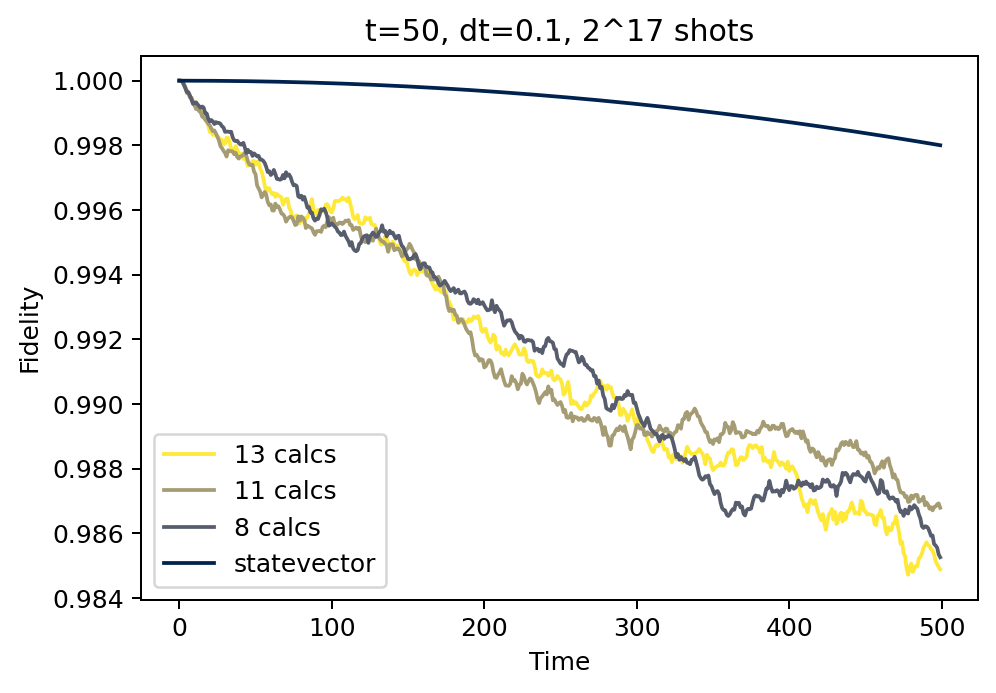

In [97]:
colors = plt.cm.cividis(np.linspace(0, 1, 4))
colors = np.flip(colors, axis=0)
fig, ax = plt.subplots(dpi = 180)
ax.set_xlabel('Time')
ax.set_ylabel('Fidelity')
ax.set_title('t=50, dt=0.1, 2^17 shots')
ax.plot(list(range(int(t/dt))), np.load('13_calcs,2^17 shots.npy'), label='13 calcs', color = colors[0])
ax.plot(list(range(int(t/dt))), np.load('11_calcs,2^17 shots.npy'), label='11 calcs', color = colors[1])
ax.plot(list(range(int(t/dt))), np.load('8_calcs,2^17 shots.npy'), label='8 calcs', color = colors[2])
ax.plot(list(range(int(t/dt))), np.load('35_calcs,statevector.npy'), label='statevector', color = colors[3])
plt.legend()
plt.show()